Ce script permet de faire une évaluation des modèles appris pour le dépistage du glaucome, selon plusieurs modalités. Premièrement, nous évaluons le modèle en end-to-end (dernière couche de prédiction), mais aussi en feature extraction en le combinant avec deux méthodes de classification : classification des features via un algo SVM et classfication des features via un algo de matching.

In [1]:
!pip3 install --user keras scikit-learn pandas opencv-python

     |████████████████████████████████| 378kB 7.6MB/s eta 0:00:01
     |████████████████████████████████| 7.1MB 24.5MB/s eta 0:00:01
     |████████████████████████████████| 10.1MB 28.5MB/s eta 0:00:01
     |████████████████████████████████| 28.2MB 15.0MB/s eta 0:00:01
     |████████████████████████████████| 276kB 16.2MB/s eta 0:00:01
     |████████████████████████████████| 296kB 18.4MB/s eta 0:00:01
     |████████████████████████████████| 512kB 24.0MB/s eta 0:00:01
Failed to build pyyaml
    Running setup.py install for pyyaml ... done
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
# import the necessary packages

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50, ResNet50V2
from keras.layers import Input, AveragePooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, SGD, RMSprop, Adagrad
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
# Load data: images and labels

data = []
labels = []

data = np.array(np.load("../data/all_images_kimeye.npy"))
labels = np.array(np.load("../data/all_labels_kimeye.npy"))
labels = labels.astype(int)

In [5]:
# shuffle the whole dataset

shuffle = list(zip(data, labels))
np.random.seed(42)
np.random.shuffle(shuffle)
data = np.array([shuffle[i][0] for i in range(len(shuffle))])
labels = np.array([shuffle[i][1] for i in range(len(shuffle))])
del shuffle

In [6]:
lb = LabelBinarizer()
#labels = lb.fit_transform(labels)
one_hot_labels = np_utils.to_categorical(labels)

In [7]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
	test_size=0.25, random_state=42)

(trainX, testX, one_hot_trainY, one_hot_testY) = train_test_split(data, one_hot_labels, 
	test_size=0.25, random_state=42)

In [61]:
#model = load_model("../models/VGG16/VGG16_fine_tuned_modelVGG16_fine_tuning__-7__SGD_0.0001_0.9_1e-06_16.h5")
#model = load_model("../models/VGG16/VGG16_fine_tuned_modelVGG16_fine_tuning__-7_256_0.0_SGD_0.0001_0.9_1e-06_16.h5")

model = load_model("../models/ResNet50V2/ResNet50V2_fine_tuned_modelResNet50V2__-1_SGD_0.0001_0.9_1e-06_8.h5")
#ResNet50V2_fine_tuned_modelResNet50V2__-1_SGD_0.0001_0.9_1e-06_8.h5

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [19]:
predictions = model.predict(testX, batch_size=1)
report = classification_report(one_hot_testY.argmax(axis=1),
	predictions.argmax(axis=1), digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9187    0.9187    0.9187       209
           1     0.9040    0.9040    0.9040       177

    accuracy                         0.9119       386
   macro avg     0.9113    0.9113    0.9113       386
weighted avg     0.9119    0.9119    0.9119       386



In [20]:
from sklearn.metrics import roc_auc_score

roc_auc_score(one_hot_testY.argmax(axis=1),
	predictions.argmax(axis=1))

0.9113075446706134

In [22]:
# Création du modèle pour l'extraction des vecteurs d'attributs de chaque image (256 pour VGG16)
features_model = Model(inputs=model.input, outputs=model.get_layer('dense_1').output)

In [23]:
def process_image(image):
    
    expand_image = np.expand_dims(image, axis=0)
    processed_image = np.array(expand_image)
    
    return processed_image
    

In [24]:
# Extraction des attributs et des labels des images de train

features_matrix = []
features_label = []

for i in range(0, len(trainX)):
    image = trainX[i]
    processed_image = process_image(image)
    features = features_model.predict(processed_image).flatten()
    features_matrix.append(features)
    features_label.append(trainY[i])

features_matrix = np.array(features_matrix)
features_label = np.array(features_label)

In [235]:
"""
def extract_features(samples, sample_count):
        
    features = np.zeros(shape=(sample_count, 512))
    for i, image in enumerate(samples):
        
        # Invoke the convolutional base
        features_batch = features_model.predict(image)
        
        # Store the transformed features and the labels
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        
        if (i+1) * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
            
    return features

features_matrix = extract_features(trainX, len(trainX))
print(features.shape)
"""

In [14]:
print(features_matrix.shape)
print(features_label)

(1158, 512)
[1 0 1 ... 1 0 1]


In [25]:
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, cross_validate, cross_val_predict
# Package permettant de lancer un classifieur SVM
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
clf = SVC(kernel='rbf', random_state=0, gamma=0.002048, C=1) # création du noyau SVM
#clf = SVC(kernel='linear', C=1)
clf.fit(features_matrix, features_label) # apprentissage

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.002048, kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [19]:
test_image = process_image(testX[208])
test_feature = features_model.predict(test_image)
label = clf.predict(test_feature)

In [222]:
print(label)

[0]


In [27]:
# Extraction des attributs des images de test
test_features_matrix = []

for i in range(0, len(testX)):
    image = testX[i]
    processed_image = process_image(image)
    test_features = features_model.predict(processed_image).flatten()
    test_features_matrix.append(test_features)

test_features_matrix = np.array(test_features_matrix)

In [28]:
print(test_features_matrix.shape)

(386, 256)


In [35]:
# Classification des images de test
predicted_labels = clf.predict(test_features_matrix)

In [36]:
# Prédiction SVM
print(predicted_labels)

[0 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1
 0 1 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1
 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0
 1 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 1
 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0
 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1 0 0
 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 1
 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1
 0 1 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1
 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1]


In [37]:
# Vérité-terrain
print(testY)

[0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 1 1
 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1
 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 1 0 0 0
 1 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0
 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 0
 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1
 0 0 0 1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1
 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1
 1 1 0 0 1 1 1 0 1 1 0 0 0 1 0 1]


In [38]:
conf_mat = confusion_matrix(testY, predicted_labels) # matrice de confusion
print("Obtained confusion matrix on test data: ")
print(conf_mat)
print(classification_report(testY, predicted_labels, digits=4)) # Résultats de métriques


Obtained confusion matrix on test data: 
[[184  25]
 [ 12 165]]
              precision    recall  f1-score   support

           0     0.9388    0.8804    0.9086       209
           1     0.8684    0.9322    0.8992       177

    accuracy                         0.9041       386
   macro avg     0.9036    0.9063    0.9039       386
weighted avg     0.9065    0.9041    0.9043       386



In [39]:
from sklearn.metrics import roc_auc_score

roc_auc_score(testY, predicted_labels)

0.9062930824750629

In [1]:
# A partir de la matrice d'attributs correspondant à la base de training, on construit deux vecteurs moyennes associés
# à chaque classe : glaucome et sain

def extract_feature_vector(feature_matrix, labels, label):

    matrix = np.array(features_matrix[labels==label])
    print(matrix.shape)
    feature_vector = np.mean(matrix, axis=0)
    return feature_vector


In [41]:
# Pour chaque matrice de features associée à chaque classe, on calcule un vecteur d'attributs moyen

healthy_vector = extract_feature_vector(features_matrix, trainY, 0)
glaucomatous_vector = extract_feature_vector(features_matrix, trainY, 1)

print(healthy_vector.shape)

(579, 256)
(579, 256)
(256,)


In [42]:
import scipy

In [43]:
# Fonction de calcul de la distance entre deu vecteurs x et y: on peut spécifier en paramètre

from scipy.spatial.distance import cosine, jaccard, minkowski, mahalanobis
from math import*

def compute_distance(x, y, dist_type):
    if dist_type == 'eucl':
        return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))
    if dist_type == 'manh':
        return sum(abs(a-b) for a, b in zip(x, y))
    if dist_type == 'cos':
        return cosine(x,y)
    if dist_type == 'mink':
        return minkowski(x,y, 3)
    if dist_type == 'maha':
        return mahalanobis(x,y)

In [ ]:
# vérifier et tester les calculs de distance

In [44]:
# A partir de la matrice d'attributs de la base de test, on compare chaque vecteur d'attributs aux vecteurs "modèles" issus de
# chaque classe grâce à la fonction de calcul de distance

def predict_label(feature_vector, healthy_vector, glaucomatous_vector, dist_type):
        
        dist_healthy = compute_distance(feature_vector, healthy_vector, dist_type)
        dist_glaucomatous = compute_distance(feature_vector, glaucomatous_vector, dist_type)
        
        if dist_healthy < dist_glaucomatous:
            return 0
        else:
            return 1

In [58]:
predicted_labels = []

for i, feature_vector in enumerate(test_features_matrix):
    predicted_label = predict_label(feature_vector, healthy_vector, glaucomatous_vector, 'manh')
    predicted_labels.append(predicted_label)

predicted_labels = np.array(predicted_labels)
    
print(predicted_labels)
print(testY)

[0 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 1 1 1 0 1 1 0 1 1 1
 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1
 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0
 1 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 1
 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0
 1 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1 0 0
 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 1 1 1
 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1
 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1
 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1]
[0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 1 1
 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1
 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0

In [59]:
conf_mat = confusion_matrix(testY, predicted_labels)
print("Obtained confusion matrix on test data: ")
print(conf_mat)
print(classification_report(testY, predicted_labels, digits=4))

Obtained confusion matrix on test data: 
[[170  39]
 [  8 169]]
              precision    recall  f1-score   support

           0     0.9551    0.8134    0.8786       209
           1     0.8125    0.9548    0.8779       177

    accuracy                         0.8782       386
   macro avg     0.8838    0.8841    0.8782       386
weighted avg     0.8897    0.8782    0.8783       386



In [60]:
from sklearn.metrics import roc_auc_score

roc_auc_score(testY, predicted_labels)

0.8840996945368043

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


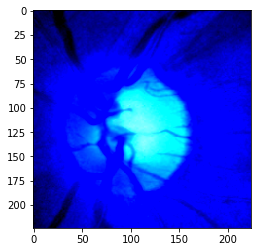

In [263]:
image = testX[3]
plt.imshow(image)
plt.show()
